In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import os
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
os.chdir("C:/Users/Administrator/Desktop/interview/new")

In [2]:
#Read csv files
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Data preparation train

In [3]:
train.head(4)

,Key,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,?,40.83,3.500,u,g,i,bb,0.50,f,f,0,f,s,1160,0,-
1,2,?,32.25,1.500,u,g,c,v,0.25,f,f,0,t,g,372,122,-
2,3,?,28.17,0.585,u,g,aa,v,0.04,f,f,0,f,g,260,1004,-
3,4,?,29.75,0.665,u,g,w,v,0.25,f,f,0,t,g,300,0,-


In [4]:
#Analyze the data
print ('Rows     : ', train.shape[0])
print ('Columns  : ', train.shape[1])
print ('\nFeatures : \n', train.columns.tolist())
print ('\nMissing values :  ', train.isnull().sum().values.sum())
print ('\nUnique values :  \n', train.nunique())

Rows     :  590
Columns  :  17

Features : 
 ['Key', 'Male', 'Age', 'Debt', 'Married', 'BankCustomer', 'EducationLevel', 'Ethnicity', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'Citizen', 'ZipCode', 'Income', 'Approved']

Missing values :   0

Unique values :  
 Key               590
Male                3
Age               322
Debt              184
Married             4
BankCustomer        4
EducationLevel     15
Ethnicity          10
YearsEmployed     112
PriorDefault        2
Employed            2
CreditScore        19
DriversLicense      2
Citizen             3
ZipCode           156
Income            210
Approved            2
dtype: int64


-    358
+    232
Name: Approved, dtype: int64


Text(0.5, 1.0, 'Approved')

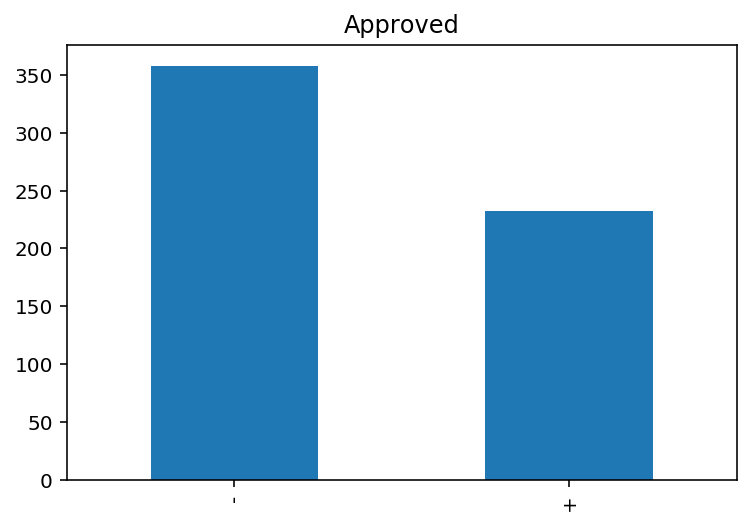

In [5]:
#Check dependent variable propotion
import matplotlib.pyplot as plt 
print(train.Approved.value_counts())
train['Approved'].value_counts().plot('bar').set_title('Approved')

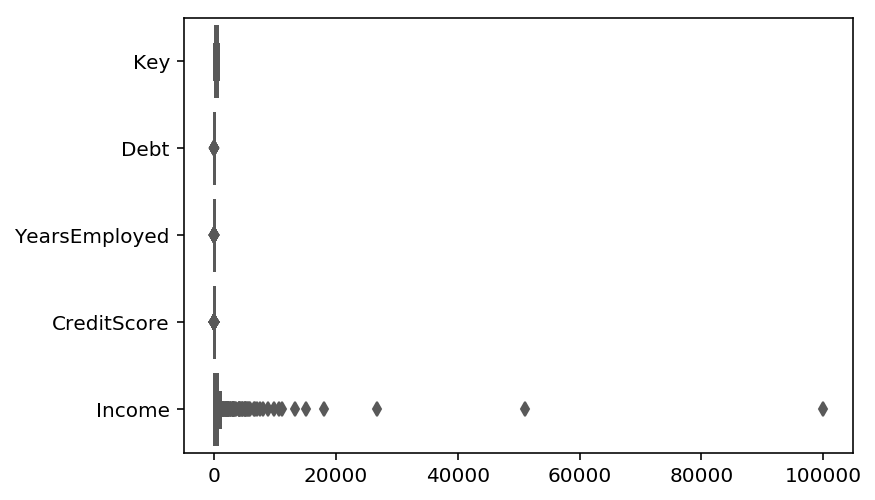

In [6]:
#Outlier Detection(Total)
sns.boxplot(data=train, orient='h', palette='Set2')

{'whiskers': [<matplotlib.lines.Line2D at 0x12ea1681ef0>,
 'caps': [<matplotlib.lines.Line2D at 0x12ea168b828>,
 'boxes': [<matplotlib.lines.Line2D at 0x12ea1681da0>],
 'medians': [<matplotlib.lines.Line2D at 0x12ea168beb8>],
 'fliers': [<matplotlib.lines.Line2D at 0x12ea168bf98>],
 'means': []}

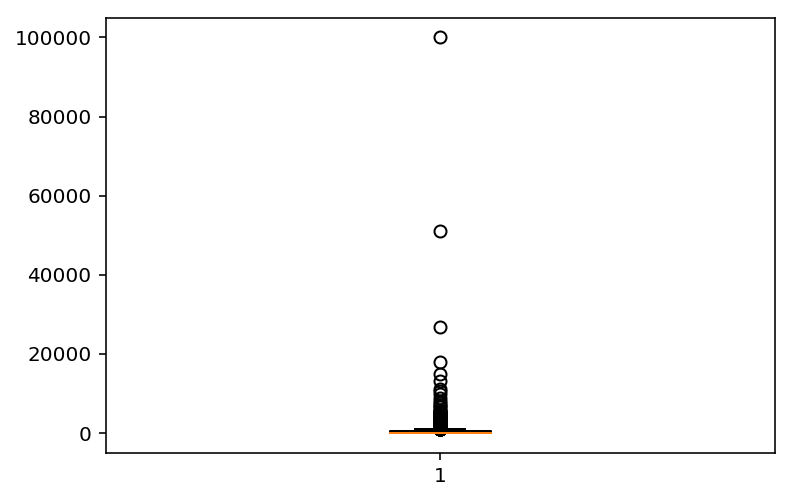

In [7]:
#Boxplot Detection(Income)
bp = plt.boxplot(train['Income'])
bp

In [8]:
#Outlier removal
train['Income'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
rownum = train[train['Income']> 2000].index
train.loc[rownum,'Income'] = 2000
train.describe()

,Key,Debt,YearsEmployed,CreditScore,Income
count,590.000000,590.000000,590.000000,590.000000,590.000000
mean,295.500000,4.609390,2.088534,2.045763,356.681356
std,170.462606,4.849569,3.198681,3.702375,643.970884
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,148.250000,1.000000,0.165000,0.000000,0.000000
50%,295.500000,2.710000,1.000000,0.000000,4.000000
75%,442.750000,7.000000,2.500000,2.000000,363.000000
max,590.000000,26.335000,20.000000,20.000000,2000.000000


In [9]:
#Missing value treatment using mode
cols = ['Key', 'Male', 'Age', 'Debt', 'Married', 'BankCustomer', 'EducationLevel', 'Ethnicity', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'Citizen', 'ZipCode', 'Income']
train[cols] = train[cols].replace('?', np.nan)
train = train.fillna(train.mode().iloc[0])
train.head(12)

,Key,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,b,40.83,3.500,u,g,i,bb,0.500,f,f,0,f,s,1160,0,-
1,2,b,32.25,1.500,u,g,c,v,0.250,f,f,0,t,g,372,122,-
2,3,b,28.17,0.585,u,g,aa,v,0.040,f,f,0,f,g,260,1004,-
3,4,b,29.75,0.665,u,g,w,v,0.250,f,f,0,t,g,300,0,-
4,5,b,26.5,2.710,y,p,c,v,0.085,f,f,0,f,s,80,0,-
5,6,b,45.33,1.000,u,g,q,v,0.125,f,f,0,t,g,263,0,-
6,7,b,42.25,1.750,y,p,c,v,0.000,f,f,0,t,g,150,1,-
7,8,b,33.17,2.250,y,p,cc,v,3.500,f,f,0,t,g,200,141,-
8,9,a,38.58,5.000,u,g,cc,v,13.500,t,f,0,t,g,980,0,-
9,10,a,19.17,0.585,y,p,aa,v,0.585,t,f,0,t,g,160,0,-


In [10]:
#Dummy variable creation
X = train.drop("Approved", axis=1)
X = pd.DataFrame({col: X[col].astype('category').cat.codes for col in X}, index=X.index)

In [11]:
#Dependent variable convert to numerical
train = train.replace(to_replace = "+", value = 1)
train = train.replace(to_replace = "-", value = 0)
y = train['Approved']
X.head(5)

,Key,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income
0,0,1,231,78,1,0,6,0,13,0,0,0,0,2,6,0
1,1,1,163,44,1,0,1,7,6,0,0,0,1,0,95,56
2,2,1,124,19,1,0,0,7,1,0,0,0,0,0,63,135
3,3,1,139,21,1,0,12,7,6,0,0,0,1,0,75,0
4,4,1,107,67,2,2,1,7,2,0,0,0,0,2,144,0


In [12]:
#Splitting datasets
import sklearn.model_selection as ms
X_train, X_test, y_train, y_test = ms.train_test_split(X,y, \
                                        test_size=0.2, random_state = 200)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (472, 16)
y_train (472,)
X_test (118, 16)
y_test (118,)


# Logistic Regression

In [13]:
#Perfom logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
Predictions = logreg.predict(X_test)
Predictions

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

In [14]:
#Prediction accuracy
from sklearn.metrics import classification_report
print(classification_report(y_test,Predictions))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        65
           1       0.95      1.00      0.97        53

   micro avg       0.97      0.97      0.97       118
   macro avg       0.97      0.98      0.97       118
weighted avg       0.98      0.97      0.97       118



In [15]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, Predictions))

[[62  3]
 [ 0 53]]


In [25]:
#Regression summary
import statsmodels.api as sm
logit_model=sm.Logit(y_test,Predictions)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.463335
         Iterations 7
                        Results: Logit
Model:              Logit            Pseudo R-squared: 0.327   
Dependent Variable: Approved         AIC:              111.3470
Date:               2019-10-21 00:36 BIC:              114.1177
No. Observations:   118              Log-Likelihood:   -54.674 
Df Model:           0                LL-Null:          -81.180 
Df Residuals:       117              LLR p-value:      nan     
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     7.0000                                     
------------------------------------------------------------------
        Coef.     Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
x1      2.8717      0.5935    4.8388    0.0000    1.7085    4.0349



# TEST

In [18]:
print ('Rows     : ', test.shape[0])
print ('Columns  : ', test.shape[1])
print ('\nFeatures : \n', test.columns.tolist())
print ('\nMissing values :  ', test.isnull().sum().values.sum())
print ('\nUnique values :  \n', test.nunique())
test.head(10)

Rows     :  100
Columns  :  16

Features : 
 ['Key', 'Male', 'Age', 'Debt', 'Married', 'BankCustomer', 'EducationLevel', 'Ethnicity', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'Citizen', 'ZipCode', 'Income']

Missing values :   0

Unique values :  
 Key               100
Male                3
Age                92
Debt               76
Married             2
BankCustomer        2
EducationLevel     13
Ethnicity           4
YearsEmployed      64
PriorDefault        2
Employed            2
CreditScore        18
DriversLicense      2
Citizen             2
ZipCode            43
Income             51
dtype: int64


,Key,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income
0,1,b,31.83,0.040,y,p,m,v,0.040,f,f,0,f,g,0,0
1,2,a,21.75,11.750,u,g,c,v,0.250,f,f,0,t,g,180,0
2,3,a,17.92,0.540,u,g,c,v,1.750,f,t,1,t,g,80,5
3,4,b,30.33,0.500,u,g,d,h,0.085,f,f,0,t,s,252,0
4,5,b,51.83,2.040,y,p,ff,ff,1.500,f,f,0,f,g,120,1
5,6,b,47.17,5.835,u,g,w,v,5.500,f,f,0,f,g,465,150
6,7,b,25.83,12.835,u,g,cc,v,0.500,f,f,0,f,g,0,2
7,8,a,50.25,0.835,u,g,aa,v,0.500,f,f,0,t,g,240,117
8,9,?,29.50,2.000,y,p,e,h,2.000,f,f,0,f,g,256,17
9,10,a,37.33,2.500,u,g,i,h,0.210,f,f,0,f,g,260,246


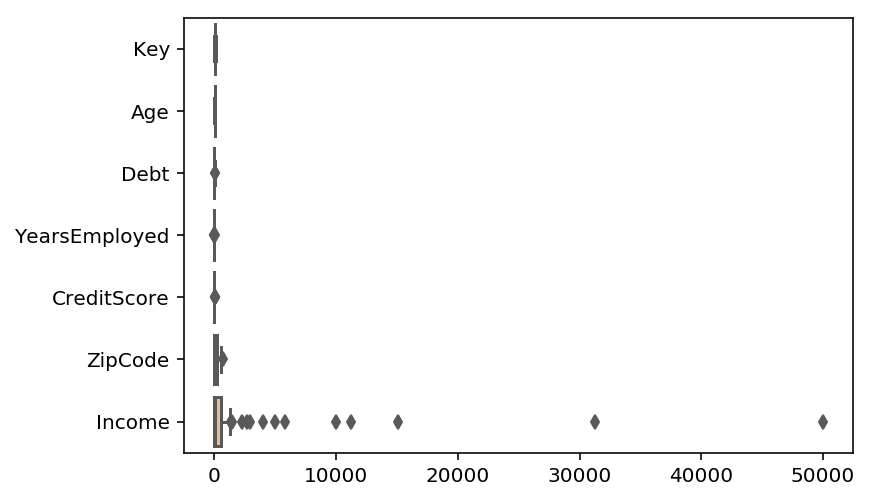

In [26]:
#Outlier Detection(Total)
sns.boxplot(data=test, orient='h', palette='Set2')

In [27]:
#Outlier removal
test['Income'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
rownum = test[test['Income']> 3000].index
test.loc[rownum,'Income'] = 3000
test.describe()

,Key,Age,Debt,YearsEmployed,CreditScore,ZipCode,Income
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,33.359400,5.639800,3.019150,4.490000,174.170000,515.640000
std,29.011492,11.521954,5.624441,4.039917,8.824318,159.721225,912.626662
min,1.000000,15.830000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,23.397500,1.000000,0.500000,0.000000,0.000000,0.000000
50%,50.500000,30.705000,4.125000,1.667500,1.000000,142.500000,26.000000
75%,75.250000,41.252500,9.508750,4.376250,6.000000,260.000000,509.250000
max,100.000000,58.670000,28.000000,28.500000,67.000000,711.000000,3000.000000


In [28]:
#Missing value treatment
test['Male'] = test['Male'].replace('?', np.nan)
test = test.fillna(test.mode().iloc[0])

In [29]:
#Dummy variable creation
Z = pd.DataFrame({col: test[col].astype('category').cat.codes for col in test}, index=test.index)
Z

,Key,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income
0,0,1,46,1,1,1,8,3,1,0,0,0,0,0,0,0
1,1,0,11,62,0,0,1,3,6,0,0,0,1,0,17,0
2,2,0,2,7,0,0,1,3,26,0,1,1,1,0,5,4
3,3,1,42,6,0,0,3,2,2,0,0,0,1,1,24,0
4,4,1,81,24,1,1,5,1,21,0,0,0,0,0,8,1
5,5,1,76,37,0,0,11,3,47,0,0,0,0,0,36,12
6,6,1,29,65,0,0,2,3,10,0,0,0,0,0,0,2
7,7,0,80,13,0,0,0,3,10,0,0,0,1,0,22,11
8,8,1,39,23,1,1,4,2,28,0,0,0,0,0,25,7
9,9,0,59,25,0,0,6,2,5,0,0,0,0,0,26,17


In [30]:
#Apply the model
final_prediction =logreg.predict(Z)
final_prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1], dtype=int64)

In [31]:
#Prediction convert to +/-
final_prediction=np.where(final_prediction > 0.5, '+', '-')
final_prediction

array(['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '+', '-', '+', '-', '-', '+', '-', '-', '+', '+',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-', '-', '-', '+', '-', '-', '-', '+', '-', '-',
       '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '+', '-', '-',
       '+', '-', '-', '-', '+', '-', '+', '-', '+'], dtype='<U1')

In [32]:
#Change to CSV format
final_prediction = pd.DataFrame(data=final_prediction)
final_prediction.to_csv("pre1.csv", sep=',', index=False)
pred = pd.read_csv("pre1.csv")
res = ['Key','Approved']
res[0] = test['Key'].values
res[1] = pred['0'].values
my_df = pd.DataFrame(res)
my_df.columns = my_df.iloc[0]
my_df = my_df.reindex(my_df.index.drop(0)).reset_index(drop=True)
my_df
my_df.to_csv("pre2.csv", sep=',', index=False)
pd.read_csv('pre2.csv', header=None).T.to_csv('final_output.csv', header=('Key','Approved'), index=False)